In [1]:
# I load the needed libraries
library(dplyr)
library(scales)
library(GoFKernel)

# library(ggplot2)
# library(rjags)
library(coda)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



In [2]:
# Function to sample from: n-dim gaussian with equal sigmas and centers
posterior_g = function (theta) {
    product = 1
    for (i in 1:length(theta)) {
            product = product * exp(-theta[i]**2)
    }
    return (product)
}

# Function to sampled from: n-dim gaussian with chosen sigmas and centers
posterior_g_inhom = function (theta) {

    sigmas = c(1:length(theta))
    centers = c(seq(length(theta), 1))

    product = 1
    for (i in 1:length(theta)) {
        product = product * exp(-(theta[i] - centers[i])**2/sigmas[i]**2)
    }

    return (product)

}


#### MCMC in ONE dimension
I create a function to build a MCMC in one dimension, using the **normal Metropolis** algorithm using a one-dimension gaussian

In [3]:
# I have to use a gaussian function in many dimensions to generate the guessed new parameters in the MCMC

# Then I create the function to extract the random number
generation_s = function (x0, std) {

    # Like in the generation of points I use inverse of cumulative distribution
    CDF = function (x) {pnorm(x, mean = x0, sd = std)}
    inv_CDF = inverse(CDF, lower = -Inf, upper = Inf)

    # I create the cumulative function (for the normal distribution I have it for free in R)
    random = runif(as.integer(length(x0)))
    new_value = inv_CDF(random)

    return(new_value)
}

# And the one to check the value of the quantiles
evaluate_Q = function(x0, std, point) {

    # For the case of the normal distribution
    dx = dnorm(point, mean = x0, sd = std)
    sx = dnorm(x0, mean = point, sd = std)

    return(sx/dx)
}

# This function is ment to return the sequence of the samples for a determined function
random_steps = function (func_wanted, theta_init, n_samples, sigma, print_accept=FALSE) {

    # Initilalizing the parameters
    current_theta = theta_init
    current_function = func_wanted(theta_init)
    samples = matrix(data = NA, nrow = n_samples, ncol = length(theta_init) + 1)

    # For statistical purposes
    accepted = 0

    # Evolution loop
    for (n in 1:n_samples) {

        # Take a guessed new theta (s in the slides) and evaluate its probability
        guessed_theta = generation_s(current_theta, sigma)
        guessed_function = func_wanted(guessed_theta)

        # Acceptance conditions
        Q_ratio = evaluate_Q(current_theta, sigma, guessed_theta)
        rho = guessed_function/current_function * Q_ratio
        # cat(guessed_theta, guessed_function, Q_ratio, rho)

        # And then update the general conditions
        if (rho > runif(1)) {
            current_theta = guessed_theta
            current_function = guessed_function
            accepted = accepted + 1
        } # else they remain unchanged and then loaded direcctly in the solutions vector

        # Saving the generated samples because R doesn't accept two elements in returns
        samples[n,] = unlist(c(current_function, current_theta))

    }

    if(print_accept) {
        cat("Acceptance rate = ", round(accepted/n_samples*100, 5), '%\n')
    }

    return(samples)
}


In [4]:
# The initial parameters are:
init = c(1)
std = c(1)
burn_in = 0
N = as.integer(1e5) + burn_in

# Evaluate then the MCMC
mcmc_g = random_steps(func_wanted = posterior_g, theta_init = init, n_samples = N, sigma = std, print_accept=TRUE)

# Selecting the sequence after the burn-in
mcmc_g = mcmc_g[burn_in:N, ]


Acceptance rate =  60.839 %


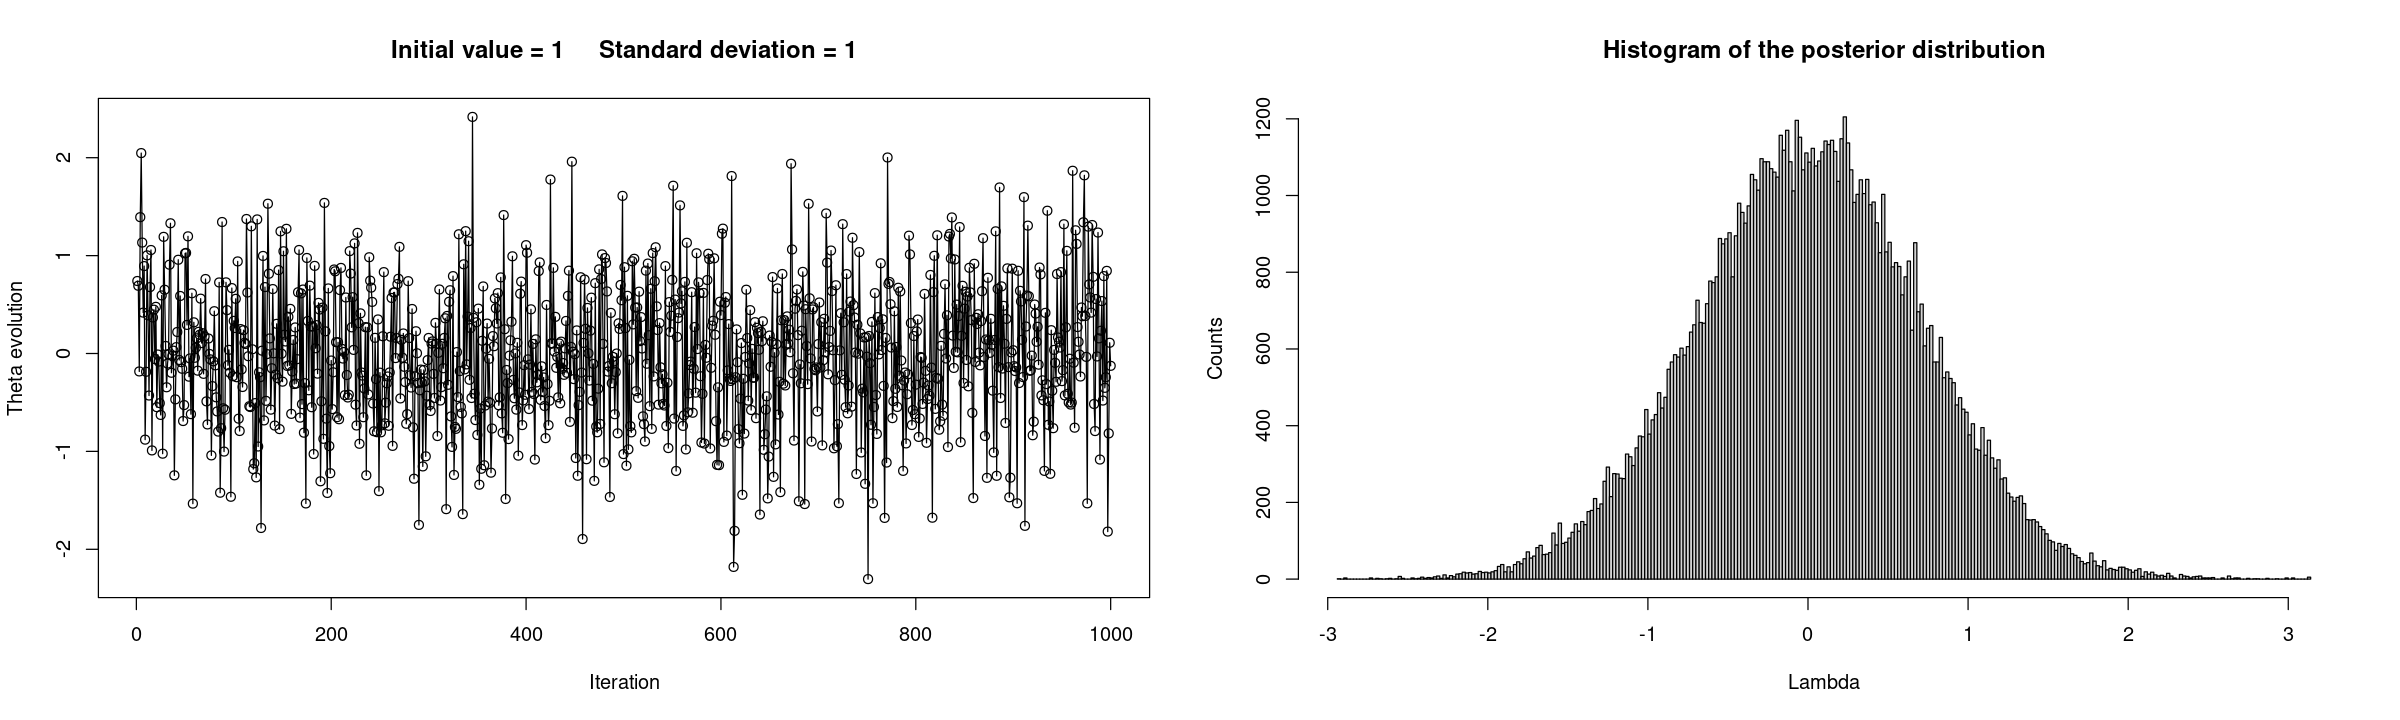

In [5]:
# Printing then the evolution of the chain and the resulting distribution
par(mfrow=c(1,2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6)

# For plot reasons I only plot a part of the chain
step = 1e2
plot_g = mcmc_g[seq(0, length(mcmc_g[,1]), step), 2]

# And then I plot
plot(1:length(plot_g), plot_g, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Theta evolution',
        main = paste0('Initial value = ', init, '     Standard deviation = ', std))
hist(mcmc_g[,2], breaks = as.integer(sqrt(length(mcmc_g[,1]))), xlab = 'Lambda', ylab = 'Counts', main = 'Histogram of the posterior distribution')


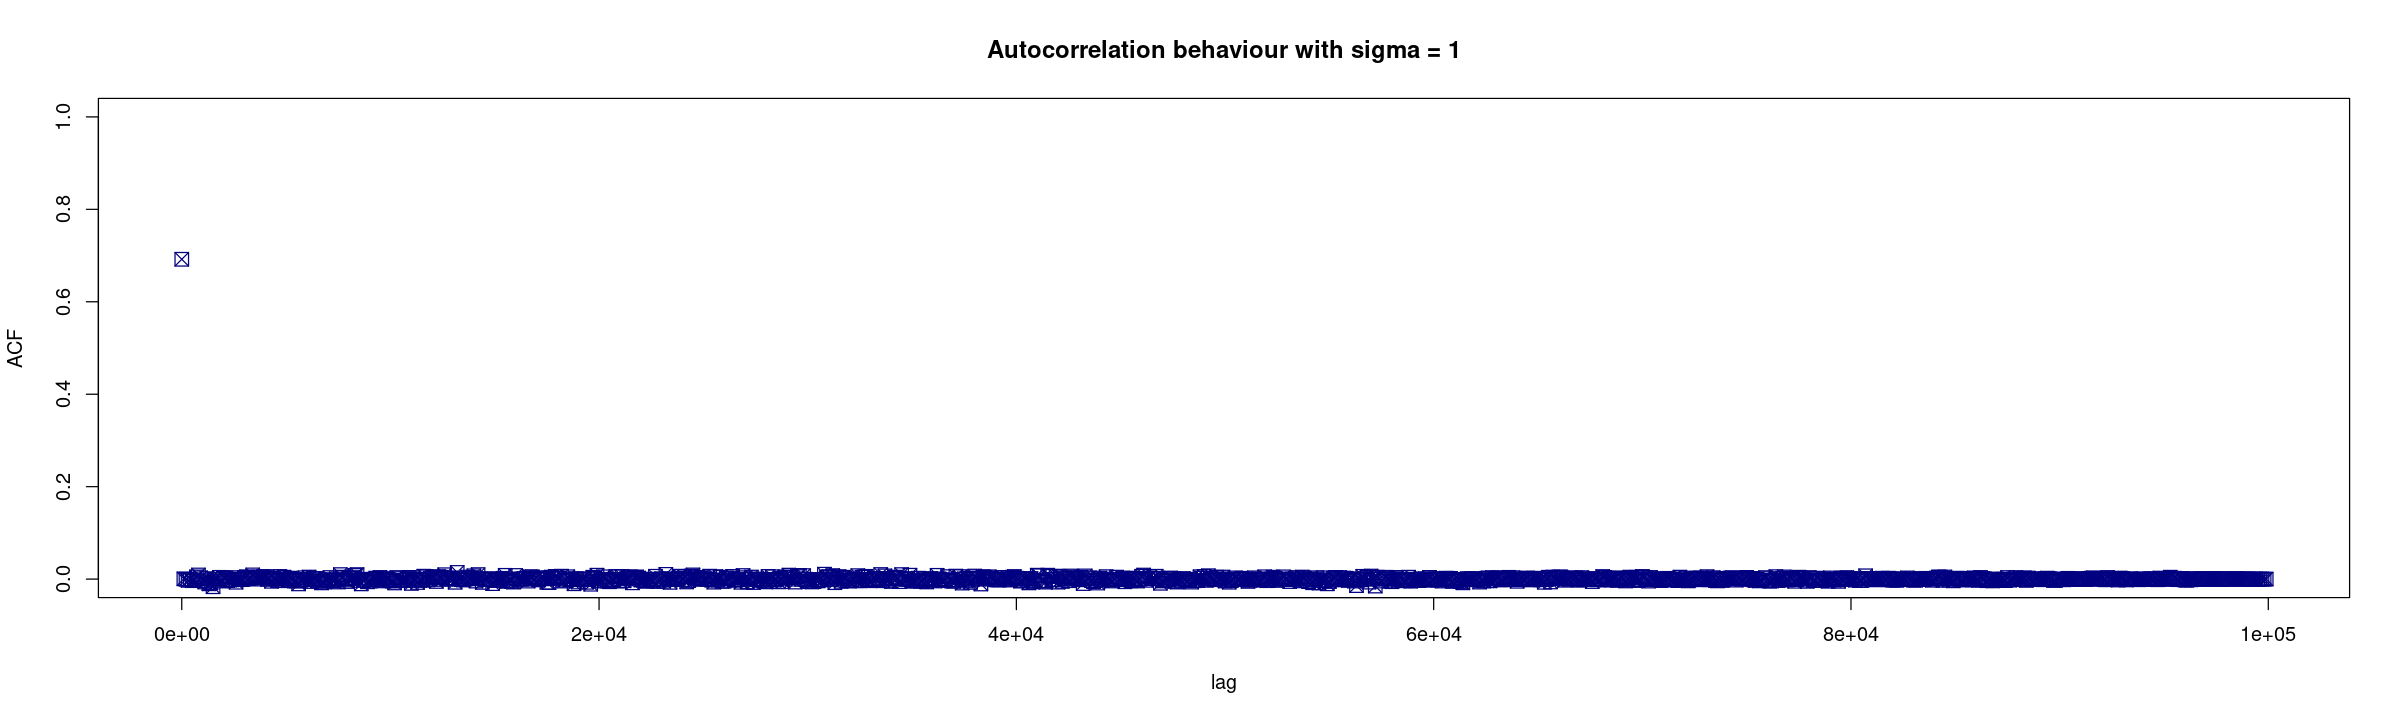

In [6]:
# I ensure that this is now a MCMC
g_chain = as.mcmc(mcmc_g[,2])

# Then I check the autocorrelation using CODA
lags = seq(1,1e5,100)
auto_g = autocorr(g_chain, lags=lags)

# And finally I plot the autocorrelation evolution:
plot(lags, auto_g, ylim=c(0,1), pch=7, col="navy", xlab="lag", ylab="ACF", cex=1.5, main = paste("Autocorrelation behaviour with sigma =", list(std)))


# MCMC in many dimensions

For the many-dimension MCMC I have to try two different methods, as explained in class: the Normal Metropolis and the Gibbs sampling, based on a different way of selecting the samples to test in the chain.  

### Normal Metropolis (multi)

First approach: create a function to build a MCMC in many dimensions, using the **normal Metropolis** algorithm for the multi-dimensional gaussian, in order to prove the effectiveness of the improvement

In [7]:
# I have to use a gaussian function in many dimensions to generate the guessed new parameters in the MCMC

# Then I create the function to extract the random number
generation_s_multi = function (x0, std) {

    # I have to loop on the dimensions, in order to use the CDF on all the dimensions
    dimension = as.integer(length(x0))
    new_value = rep(0, dimension)

    for (dim in 1:dimension) {

        # Like in the generation of points I use inverse of cumulative distribution
        CDF = function (x) {pnorm(x, mean = x0[dim], sd = std[dim])}
        inv_CDF = inverse(CDF, lower = -Inf, upper = Inf)

        # I create the cumulative function (for the normal distribution I have it for free in R)
        random = runif(as.integer(length(x0[dim])))
        new_value[dim] = inv_CDF(random)

    }

    return(new_value)
}

# And the one to check the value of the quantiles
evaluate_Q_multi = function(x0, std, point) {

    # For the case of the normal distribution
    dx = dnorm(point, mean = x0, sd = std)
    sx = dnorm(x0, mean = point, sd = std)

    return(prod(sx/dx))
}

# This function is ment to return the sequence of the samples for a determined function
random_steps_multi = function (func_wanted, theta_init, n_samples, sigma, print_accept=FALSE) {

    # Initilalizing the parameters
    current_theta = theta_init
    current_function = func_wanted(theta_init)
    samples = matrix(data = NA, nrow = n_samples, ncol = length(theta_init) + 1)

    # For statistical purposes
    accepted = 0

    # Evolution loop
    for (n in 1:n_samples) {

        # Take a guessed new theta (s in the slides) and evaluate its probability
        guessed_theta = generation_s_multi(current_theta, sigma)
        guessed_function = func_wanted(guessed_theta)

        # Acceptance conditions
        Q_ratio = evaluate_Q_multi(current_theta, sigma, guessed_theta)
        rho = guessed_function/current_function * Q_ratio
        # cat(guessed_theta, "\t", guessed_function, "\t", Q_ratio, "\t", rho, '\n')

        # And then update the general conditions
        if (rho > runif(1)) {
            current_theta = guessed_theta
            current_function = guessed_function
            accepted = accepted + 1
        } # else they remain unchanged and then loaded direcctly in the solutions vector

        # Saving the generated samples because R doesn't accept two elements in returns
        samples[n,] = unlist(c(current_function, current_theta))

    }

    if(print_accept) {
        cat("Acceptance rate = ", round(accepted/n_samples*100, 5), '%\n')
    }

    return(samples)
}


In [11]:
# The initial parameters are:
init = c(1, 1, 1)
std = c(1, 1, 1)
burn_in = 0
N = as.integer(1e5) + burn_in

# Evaluate then the 
mcmc_g = random_steps_multi(func_wanted = posterior_g_inhom, theta_init = init, n_samples = N, sigma = std, print_accept=TRUE)

# Selecting the sequence after the burn-in
mcmc_g = mcmc_g[burn_in:N, ]


Acceptance rate =  48.24 %


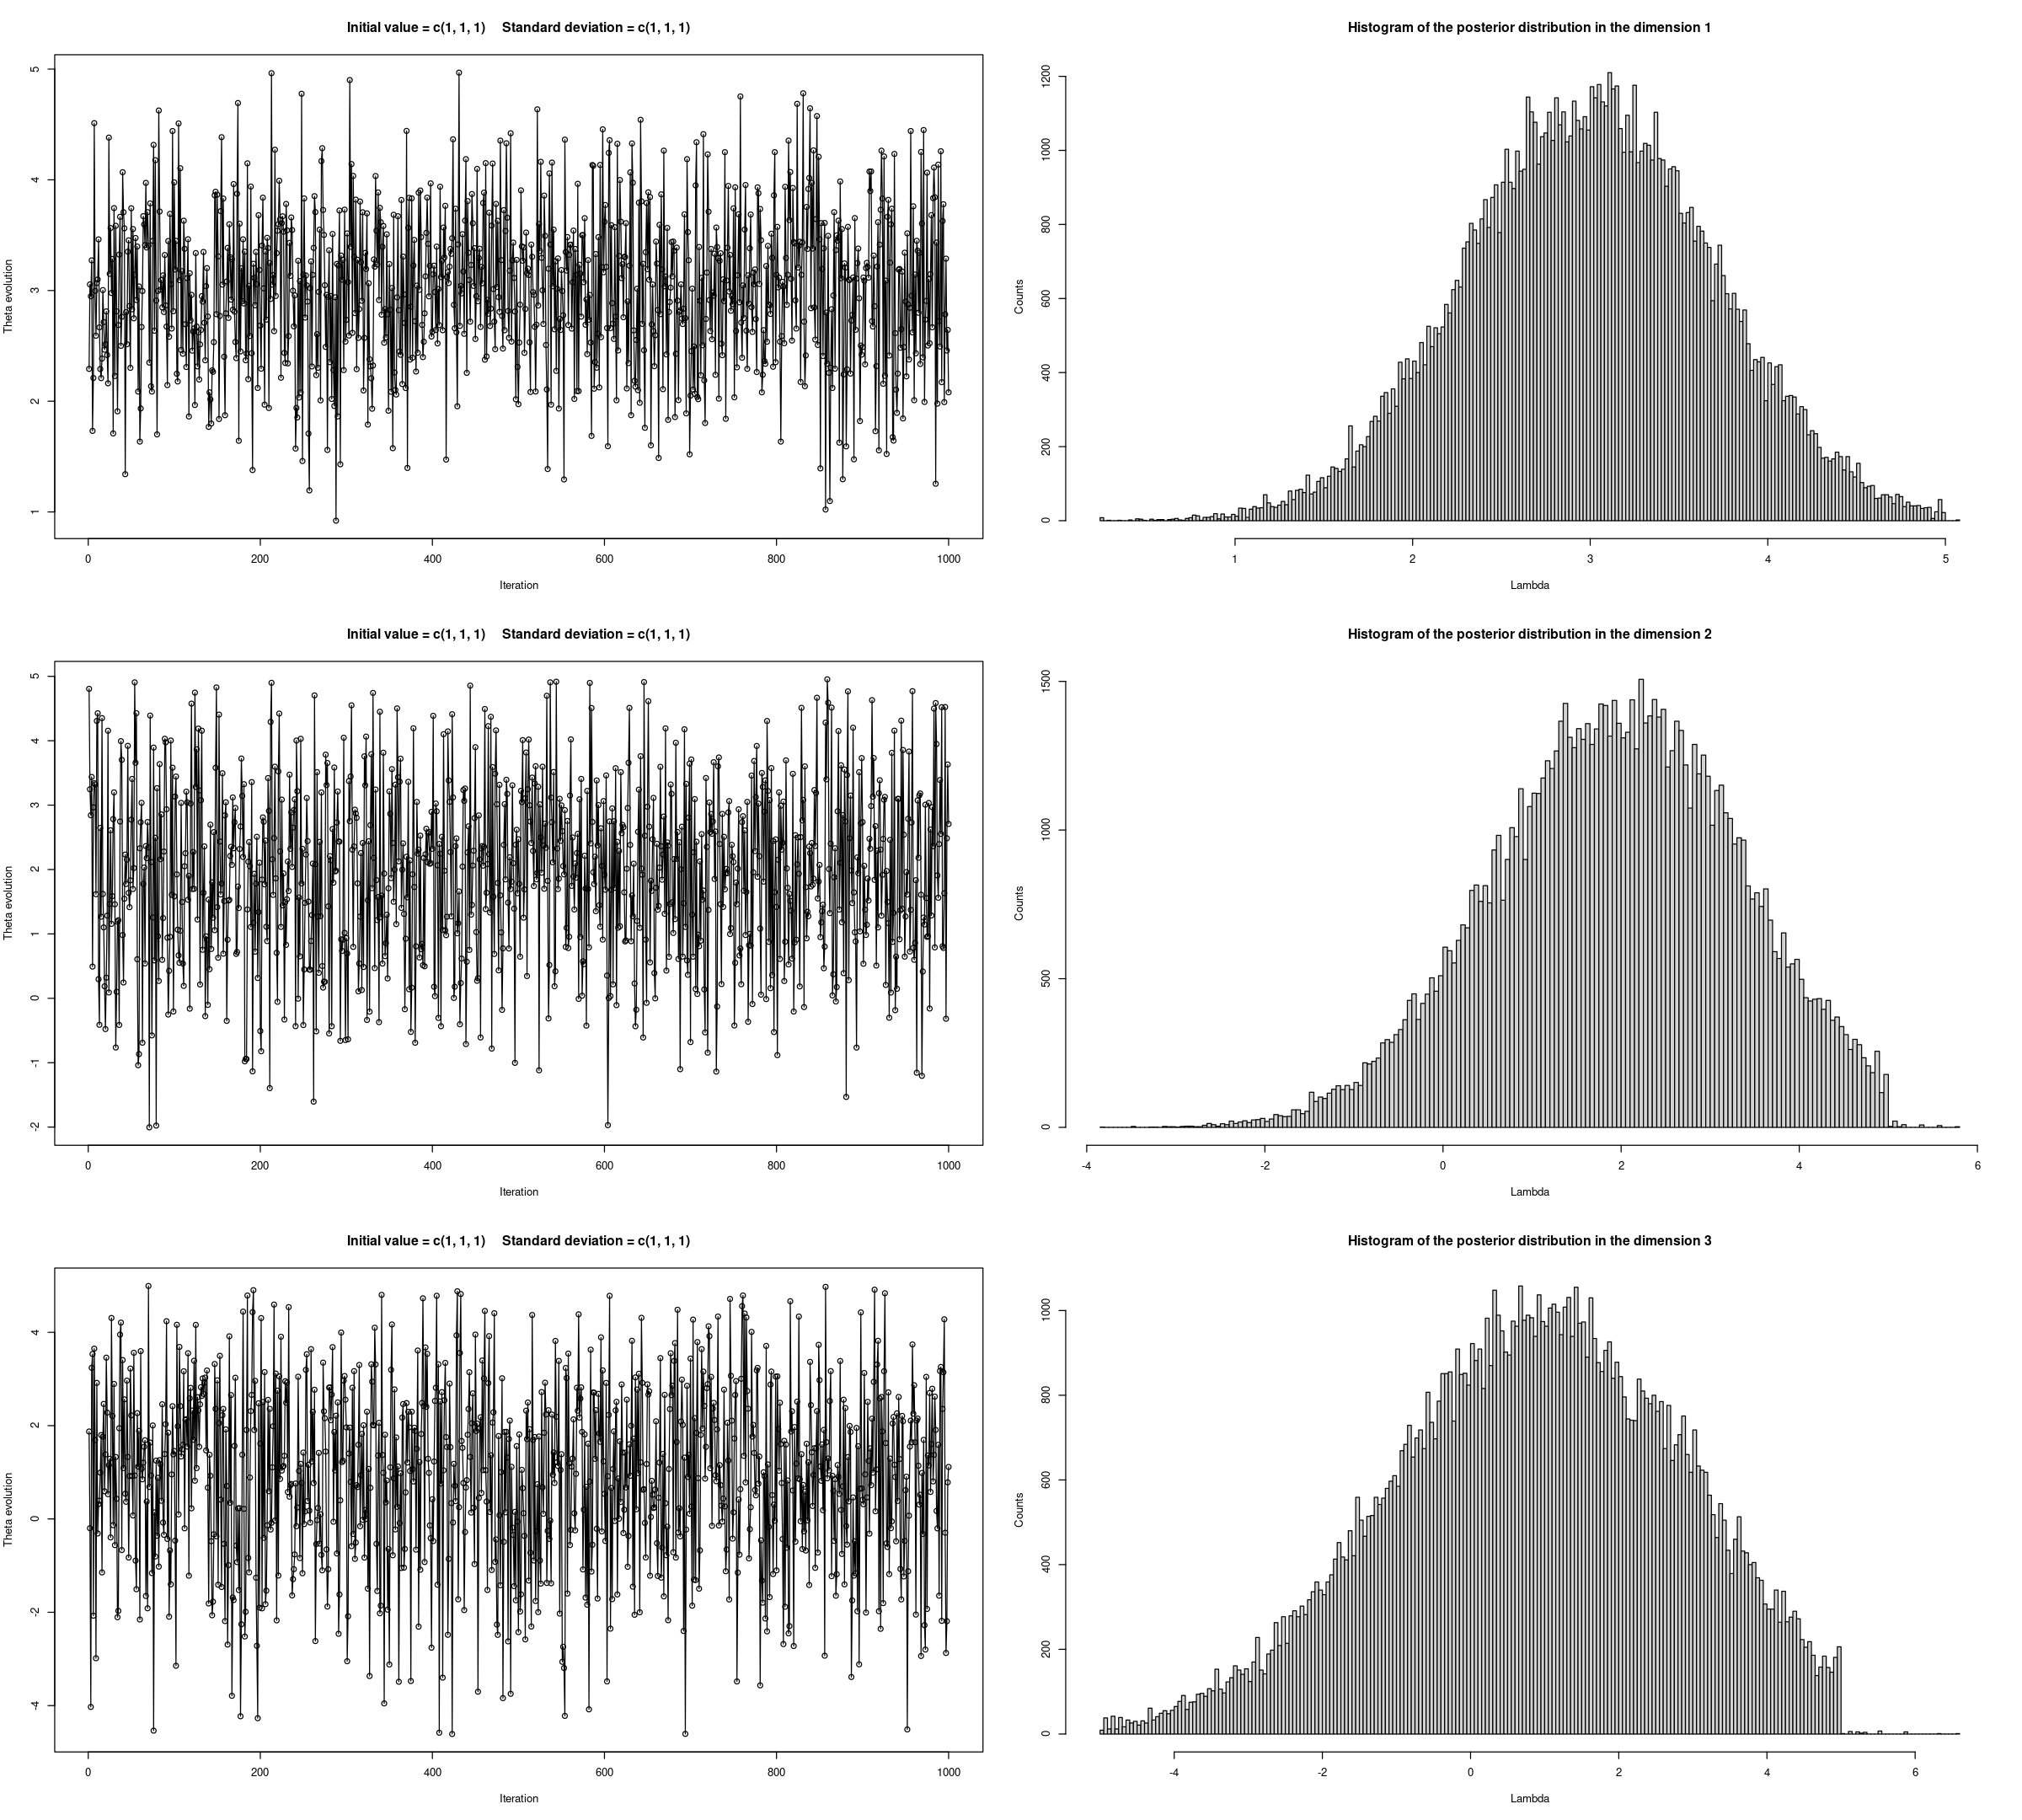

In [12]:
# Printing then the evolution of the chain and the resulting distribution
lungh = as.integer(length(mcmc_g[1,]))
step = 1e2

# Plotting every dimension of the plot
par(mfrow=c(lungh-1, 2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    plot_g = mcmc_g[seq(0, length(mcmc_g[,1]), step), dim]
    plot(1:length(plot_g), plot_g, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Theta evolution', 
        main = paste0('Initial value = ', list(init), '     Standard deviation = ', list(std)))
    hist(mcmc_g[,dim], breaks = as.integer(sqrt(length(mcmc_g[,1]))), xlab = 'Lambda', ylab = 'Counts',
        main = paste('Histogram of the posterior distribution in the dimension', dim-1))
}


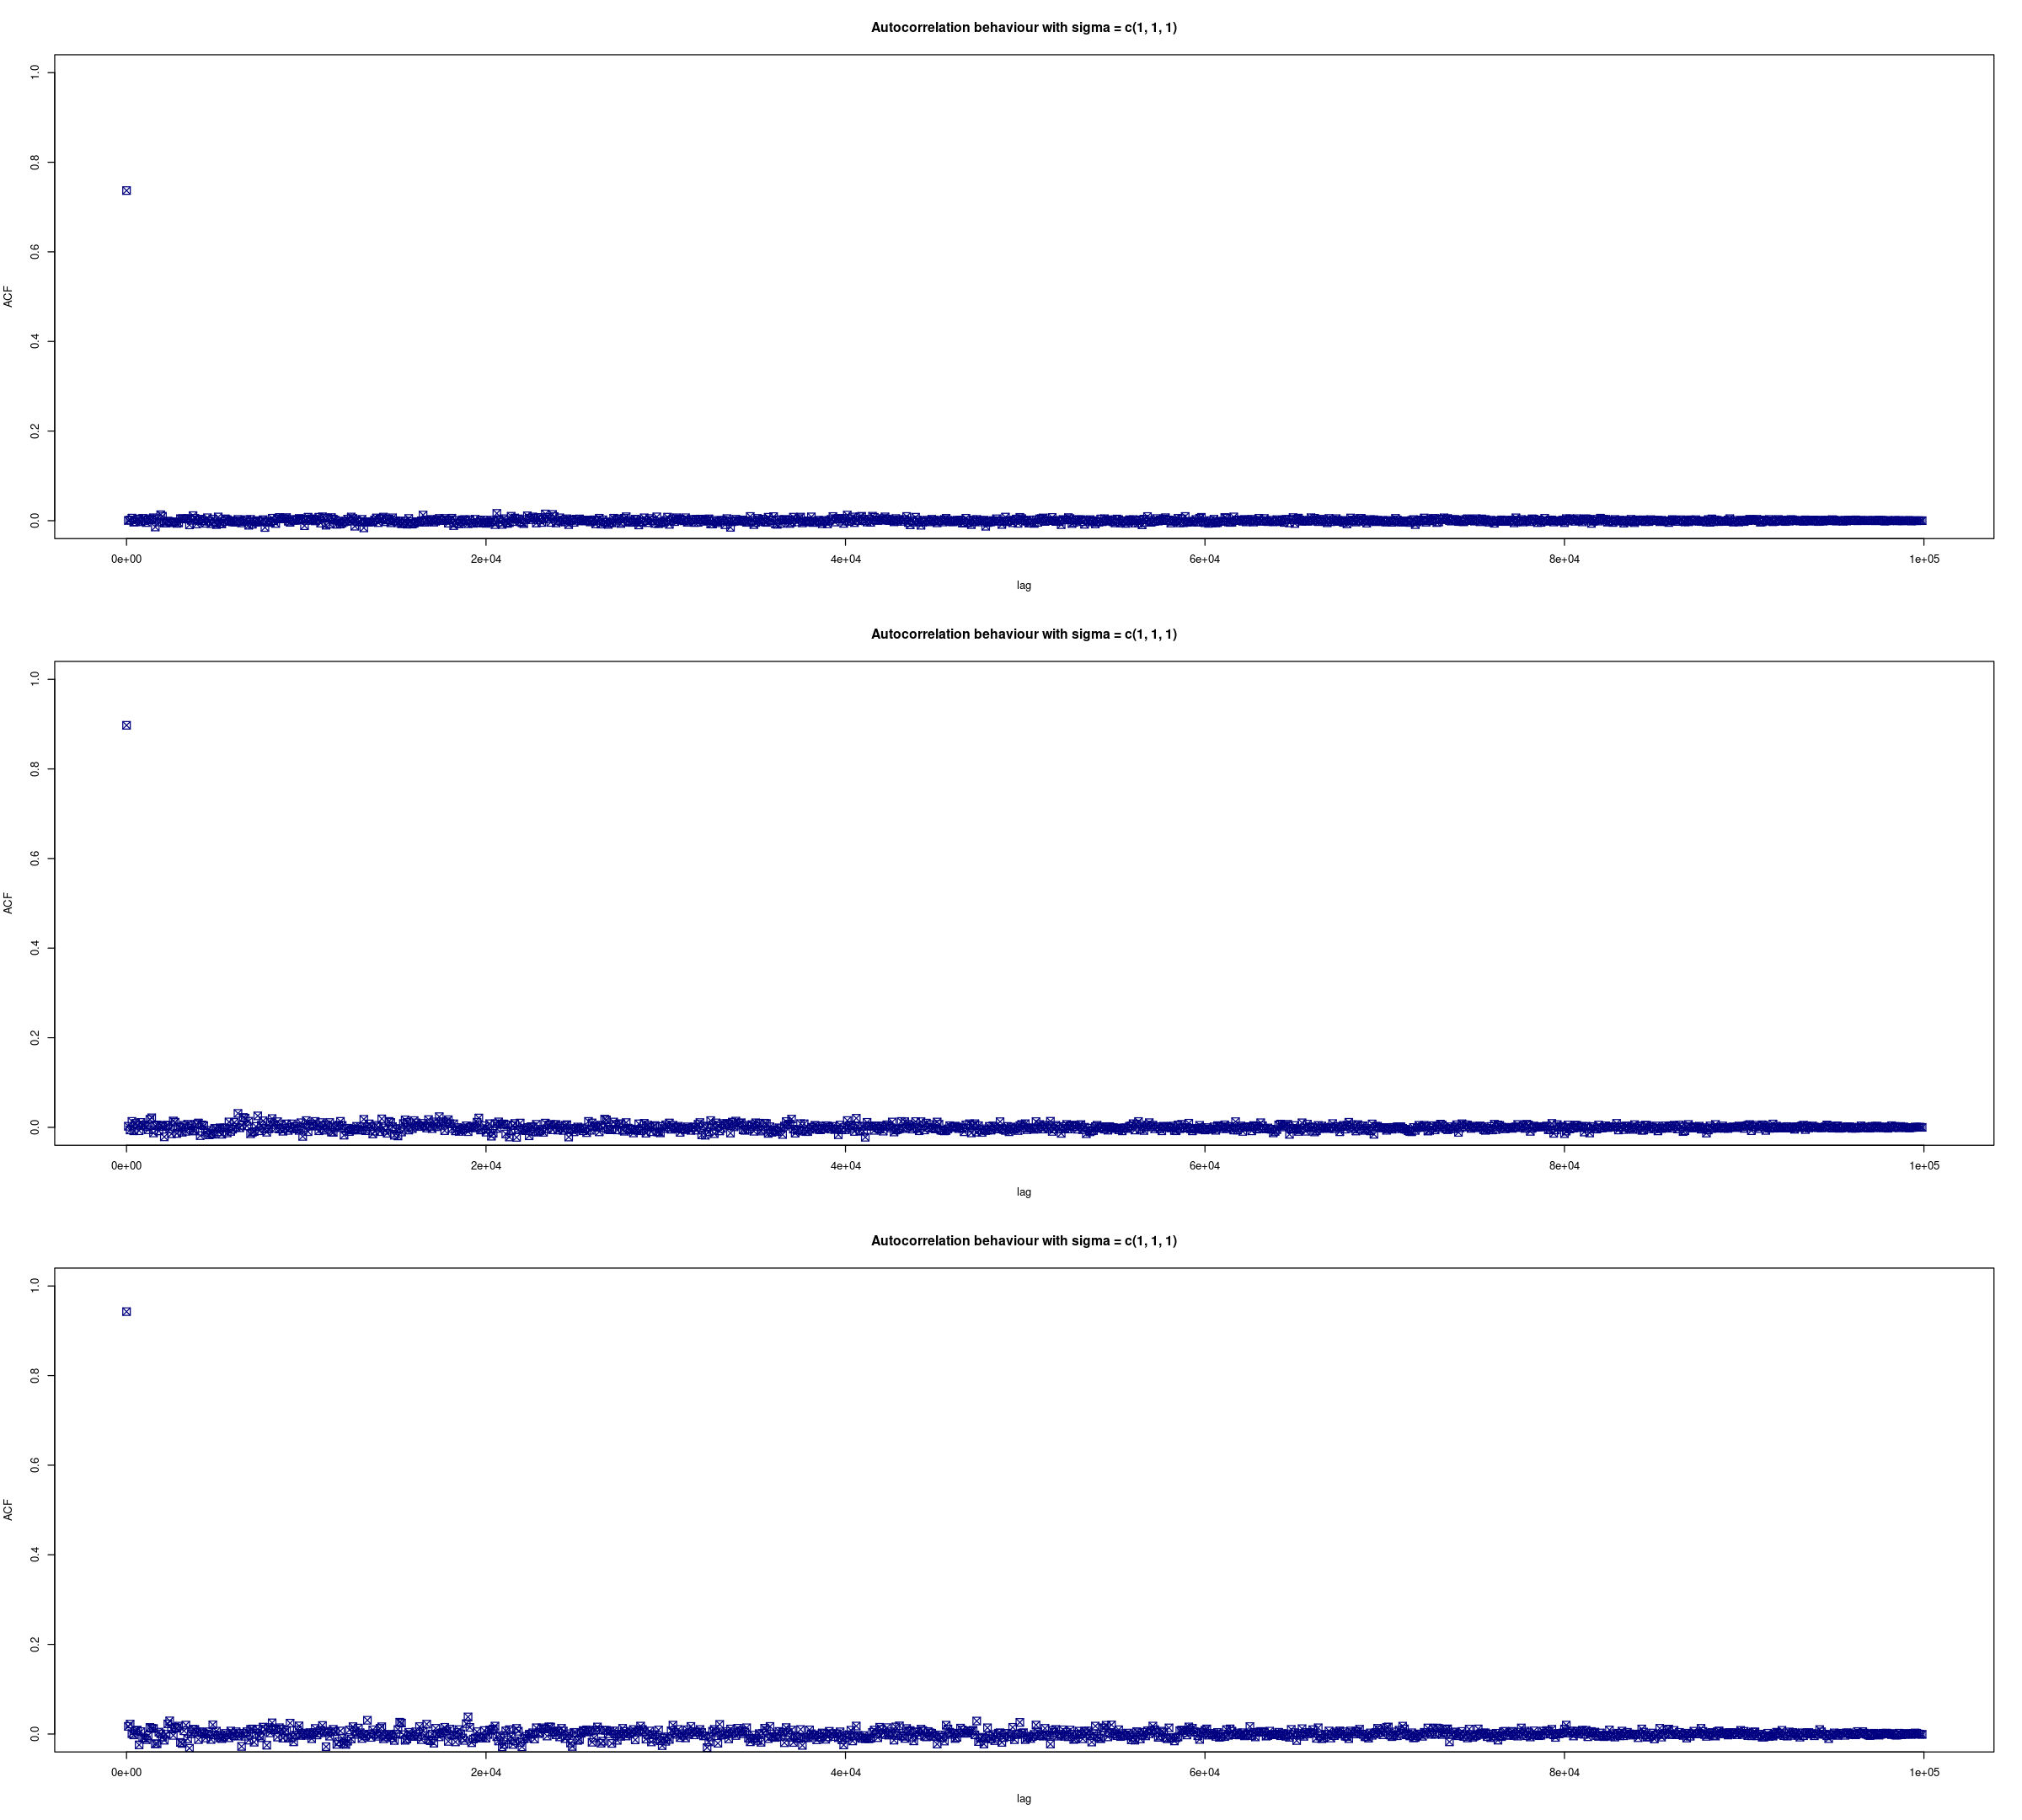

In [13]:
lungh = as.integer(length(mcmc_g[1,]))
step = 1e2

par(mfrow=c(lungh-1, 1), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    # I ensure that this is now a MCMC
    g_chain = as.mcmc(mcmc_g[,dim])

    # Then I check the autocorrelation using CODA
    lags = seq(1,1e5,100)
    auto_g = autocorr(g_chain, lags=lags)

    # And finally I plot the autocorrelation evolution:
    plot(lags, auto_g, ylim=c(0,1), pch=7, col="navy", xlab="lag", ylab="ACF", cex=1.5, main = paste("Autocorrelation behaviour with sigma =", list(std)))
}


#### Gibbs Sampling approach (gibbs)

First approach: create a function to build a MCMC in many dimensions, using the algorithm developed in the **Gibbs sampling** and the multi-dimensional gaussian, in order to prove the effectiveness of the improvement

In [14]:
# I have to use a gaussian function in many dimensions to generate the guessed new parameters in the MCMC

# Then I create the function to extract the random number
generation_s_gibbs = function (x0, std, dim) {

    # Like in the generation of points I use inverse of cumulative distribution
    CDF = function (x) {pnorm(x, mean = x0[dim], sd = std[dim])}
    inv_CDF = inverse(CDF, lower = -Inf, upper = Inf)

    # I create the cumulative function (for the normal distribution I have it for free in R)
    random = runif(1)
    new_value = inv_CDF(random)

    return(new_value)
}

# And the one to check the value of the quantiles
evaluate_Q_gibbs = function(x0, std, point) {

    # For the case of the normal distribution
    dx = dnorm(point, mean = x0, sd = std)
    sx = dnorm(x0, mean = point, sd = std)

    return(prod(sx/dx))
}

# This function is ment to return the sequence of the samples for a determined function
random_steps_gibbs = function (func_wanted, theta_init, n_samples, sigma, print_accept=FALSE) {

    # Initilalizing the parameters
    current_theta = theta_init
    current_function = func_wanted(theta_init)
    dimensions = length(theta_init)
    samples = matrix(data = NA, nrow = n_samples, ncol = dimensions + 1)

    # For statistical purposes
    accepted = 0

    # Evolution loop
    for (n in 1:n_samples) {

        guessed_theta = current_theta

        # I then can loop on the dimensions of the distribution to allpy the gibbs sampling
        for (dim in 1:dimensions) {

            # Take a guessed new theta (s in the slides) and evaluate its probability
            guessed_theta[dim] = generation_s_gibbs(current_theta, sigma, dim)
            guessed_function = func_wanted(guessed_theta)

            # Acceptance conditions
            Q_ratio = evaluate_Q_gibbs(current_theta, sigma, guessed_theta)
            rho = guessed_function/current_function * Q_ratio
            # cat(guessed_theta, "\t", guessed_function, "\t", Q_ratio, "\t", rho, '\n')

            # And then update the general conditions
            if (rho > runif(1)) {
                current_theta[dim] = guessed_theta[dim]
                current_function = guessed_function
                accepted = accepted + 1
            } # else they remain unchanged and then loaded direcctly in the solutions vector

        }

        # Saving the generated samples because R doesn't accept two elements in returns
        samples[n,] = unlist(c(current_function, current_theta))

    }

    if(print_accept) {
        cat("Acceptance rate = ", round(accepted/(n_samples*dimensions)*100, 5), '%\n')
    }

    return(samples)
}


In [15]:
# The initial parameters are:
init = c(1, 1, 1)
std = c(1, 1, 1)
burn_in = 0
N = as.integer(1e5) + burn_in

# Evaluate then the 
mcmc_g = random_steps_gibbs(func_wanted = posterior_g_inhom, theta_init = init, n_samples = N, sigma = std, print_accept=TRUE)

# Selecting the sequence after the burn-in
mcmc_g = mcmc_g[burn_in:N, ]


Acceptance rate =  59.19133 %


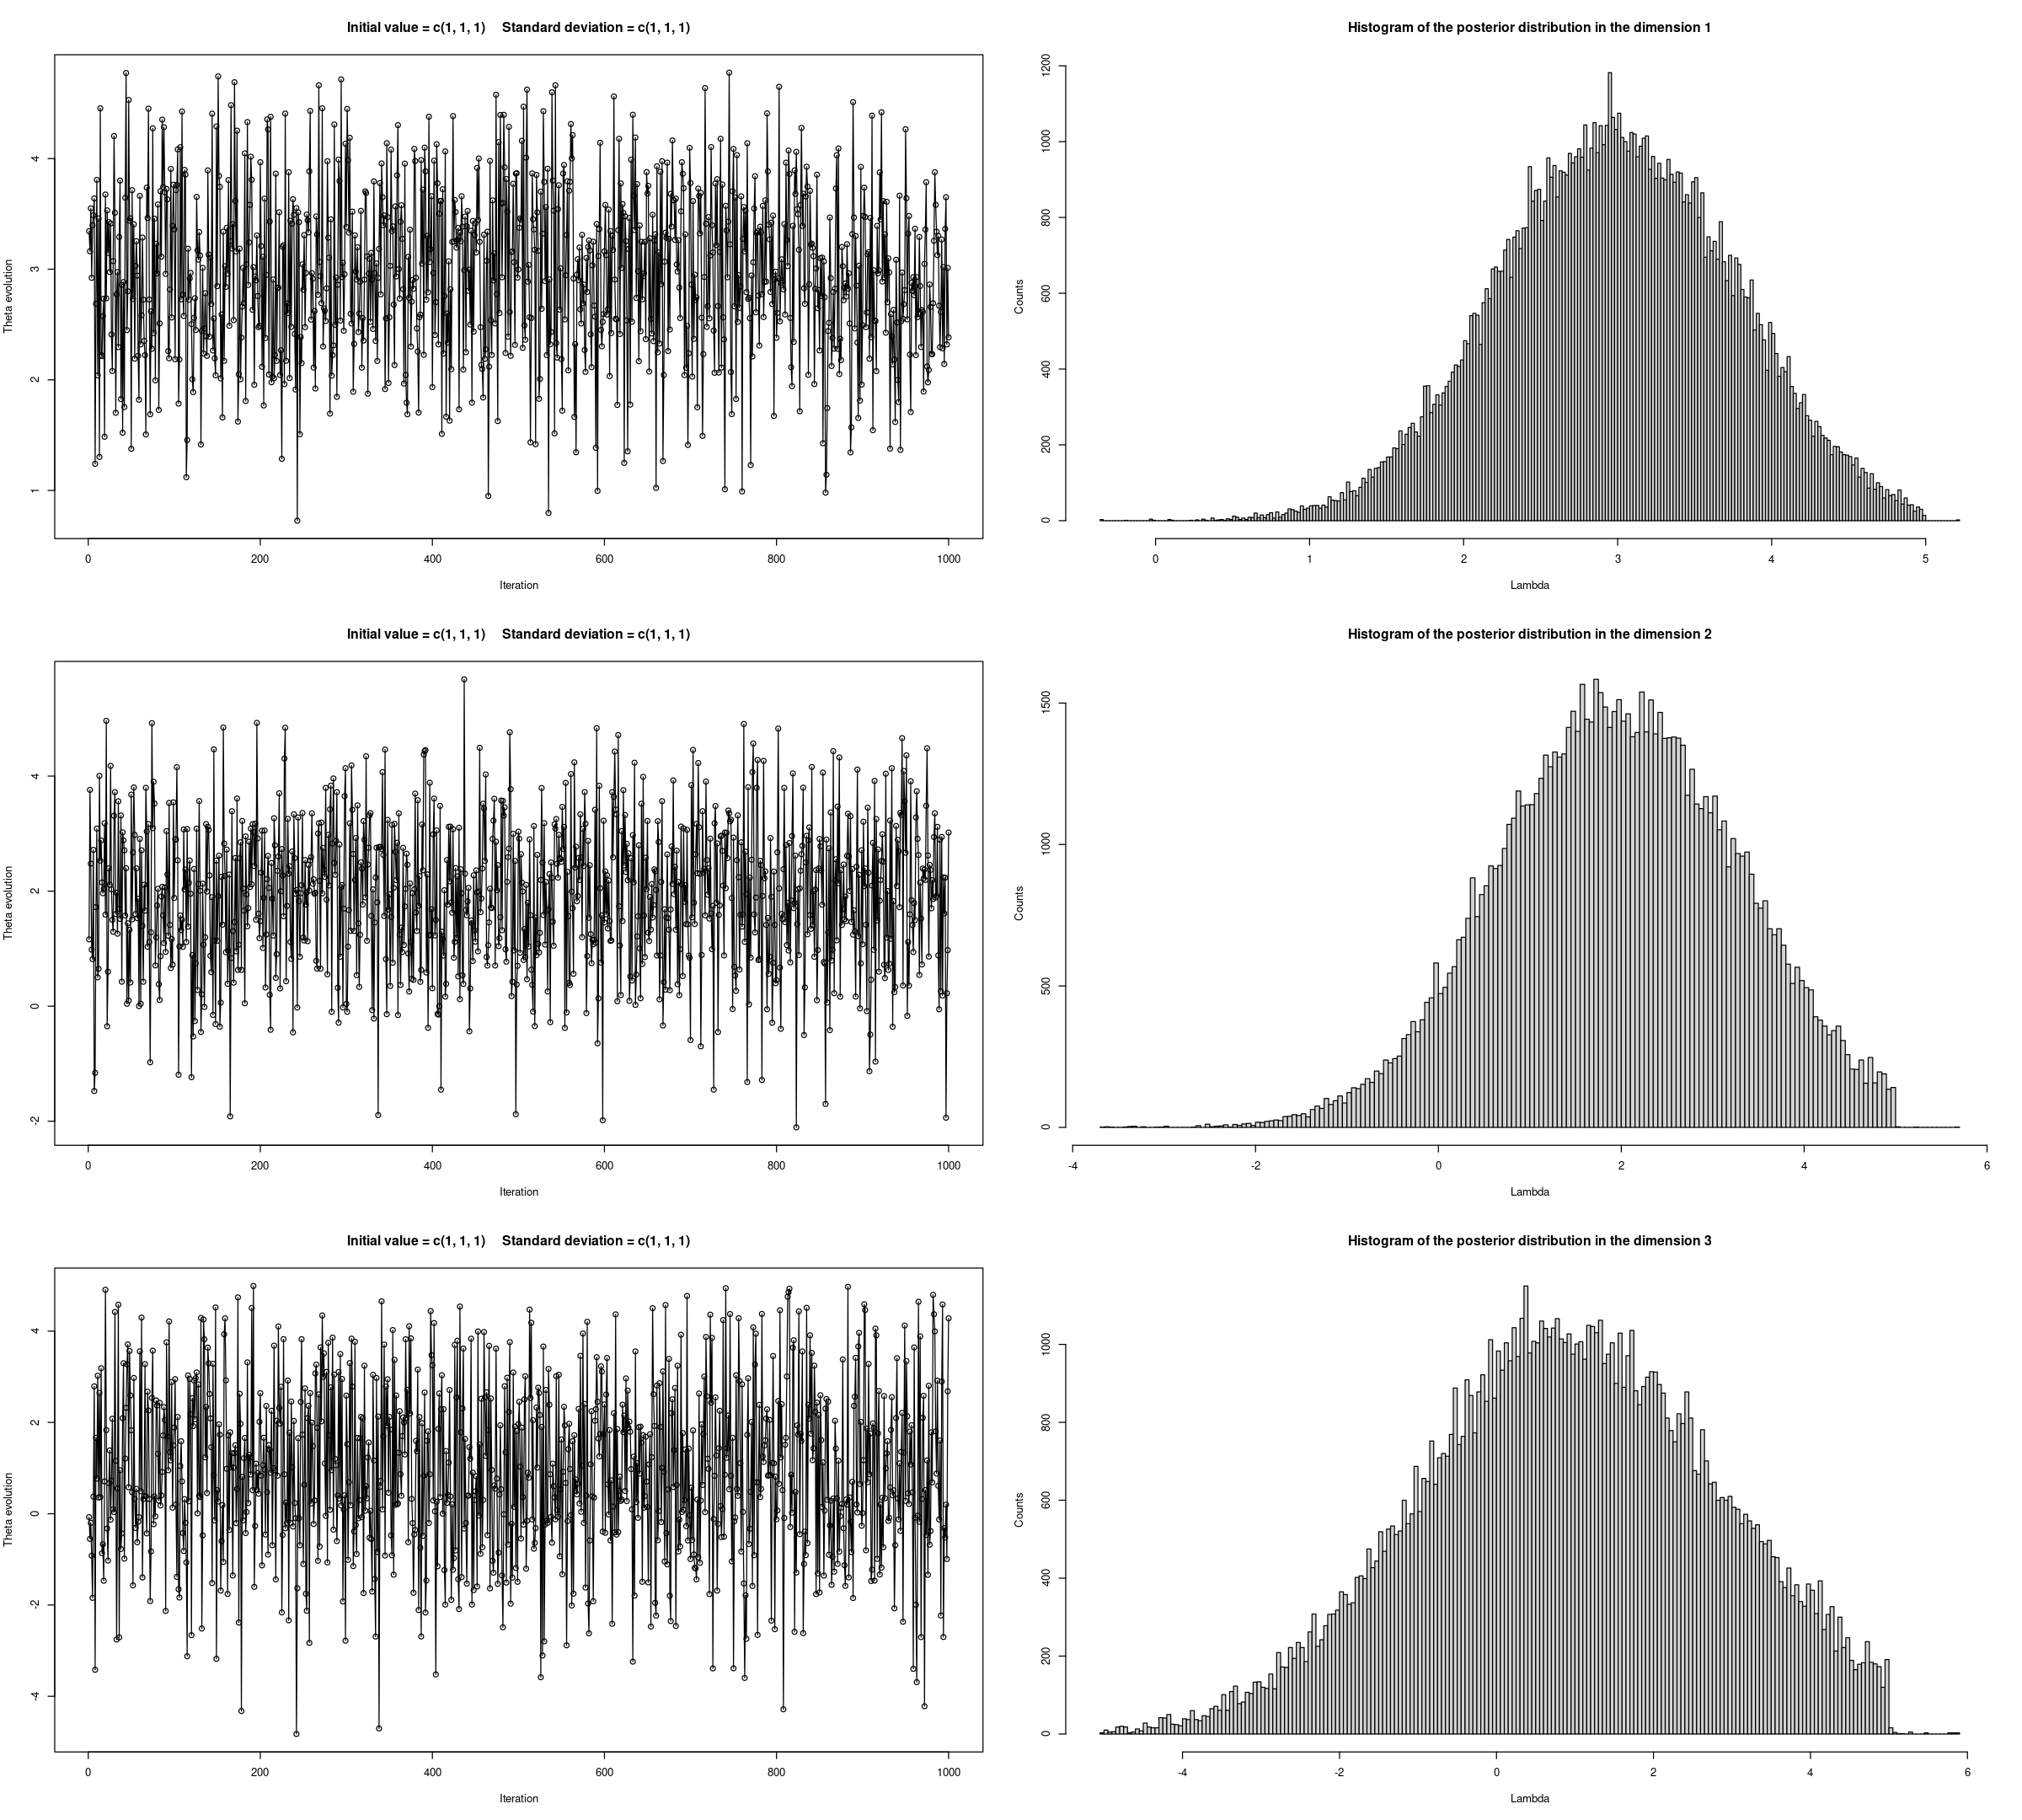

In [16]:
# Printing then the evolution of the chain and the resulting distribution
lungh = as.integer(length(mcmc_g[1,]))
step = 1e2

# Plotting every dimension of the plot
par(mfrow=c(lungh-1, 2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    plot_g = mcmc_g[seq(0, length(mcmc_g[,1]), step), dim]
    plot(1:length(plot_g), plot_g, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Theta evolution', 
        main = paste0('Initial value = ', list(init), '     Standard deviation = ', list(std)))
    hist(mcmc_g[,dim], breaks = as.integer(sqrt(length(mcmc_g[,1]))), xlab = 'Lambda', ylab = 'Counts',
        main = paste('Histogram of the posterior distribution in the dimension', dim-1))
}


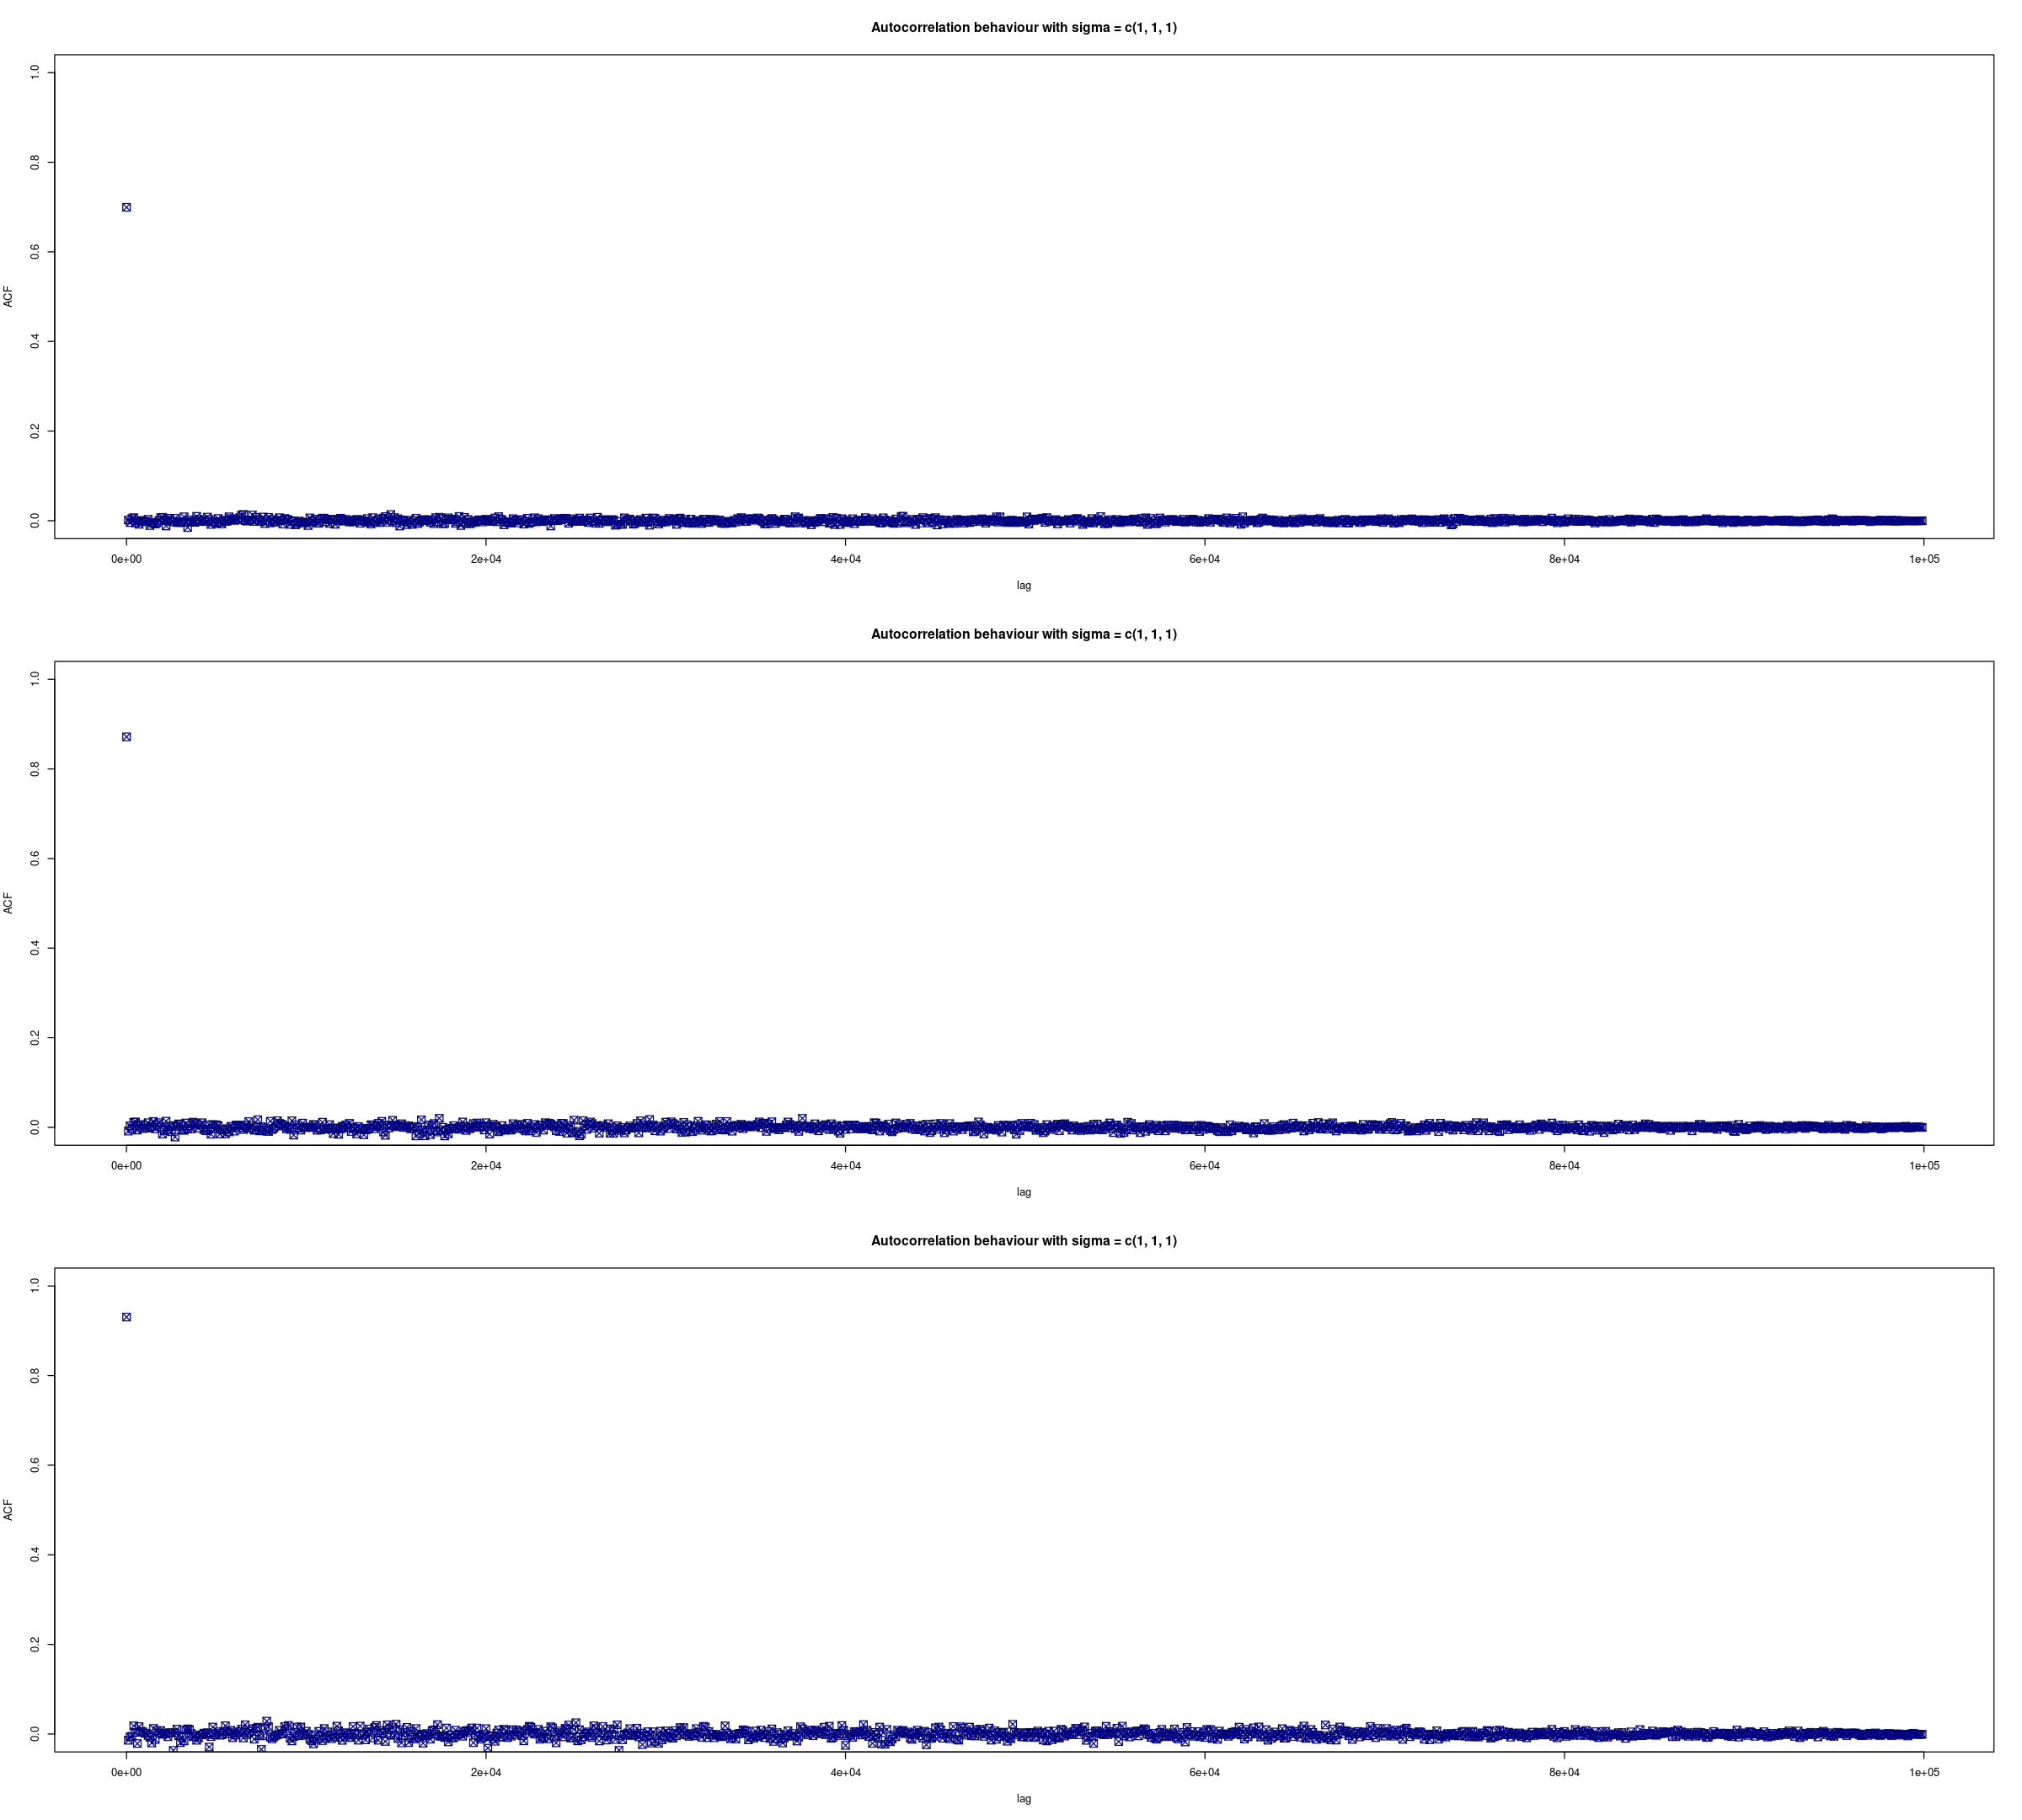

In [17]:
lungh = as.integer(length(mcmc_g[1,]))
step = 1e2

par(mfrow=c(lungh-1, 1), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    # I ensure that this is now a MCMC
    g_chain = as.mcmc(mcmc_g[,dim])

    # Then I check the autocorrelation using CODA
    lags = seq(1,1e5,100)
    auto_g = autocorr(g_chain, lags=lags)

    # And finally I plot the autocorrelation evolution:
    plot(lags, auto_g, ylim=c(0,1), pch=7, col="navy", xlab="lag", ylab="ACF", cex=1.5, main = paste("Autocorrelation behaviour with sigma =", list(std)))
}
